# Data Preprocessing

Data preprocessing is necessary since there might be some missing values or categorical variables that need to be converted to numerical. Also, there is a need for data normalization since KNN and SVM use the absolute measurement.

In [1]:
!pip install category_encoders

  Obtaining dependency information for category_encoders from https://files.pythonhosted.org/packages/7f/e5/79a62e5c9c9ddbfa9ff5222240d408c1eeea4e38741a0dc8343edc7ef1ec/category_encoders-2.6.3-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 813.1 kB/s eta 0:00:00a 0:00:01


In [2]:
# Import libraries
import pandas as pd
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
import numpy as np
from collections import Counter
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, roc_curve, auc
import time
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import matplotlib.pyplot as plt

In [4]:
# Read the data and print the information
audit_risk = pd.read_csv("audit_risk.csv")
print(audit_risk.head())
print(audit_risk.info())

   Sector_score LOCATION_ID  PARA_A  Score_A  Risk_A  PARA_B  Score_B  Risk_B  \
0          3.89          23    4.18      0.6   2.508    2.50      0.2   0.500   
1          3.89           6    0.00      0.2   0.000    4.83      0.2   0.966   
2          3.89           6    0.51      0.2   0.102    0.23      0.2   0.046   
3          3.89           6    0.00      0.2   0.000   10.80      0.6   6.480   
4          3.89           6    0.00      0.2   0.000    0.08      0.2   0.016   

   TOTAL  numbers  ...  RiSk_E  History  Prob  Risk_F  Score  Inherent_Risk  \
0   6.68      5.0  ...     0.4        0   0.2     0.0    2.4          8.574   
1   4.83      5.0  ...     0.4        0   0.2     0.0    2.0          2.554   
2   0.74      5.0  ...     0.4        0   0.2     0.0    2.0          1.548   
3  10.80      6.0  ...     0.4        0   0.2     0.0    4.4         17.530   
4   0.08      5.0  ...     0.4        0   0.2     0.0    2.0          1.416   

   CONTROL_RISK  Detection_Risk  Audit

In [5]:
# Check for null variables and replace with the mean value
print(audit_risk.isnull().sum())
mean_value = audit_risk['Money_Value'].mean()
audit_risk['Money_Value'] = audit_risk['Money_Value'].fillna(mean_value) 

Sector_score      0
LOCATION_ID       0
PARA_A            0
Score_A           0
Risk_A            0
PARA_B            0
Score_B           0
Risk_B            0
TOTAL             0
numbers           0
Score_B.1         0
Risk_C            0
Money_Value       1
Score_MV          0
Risk_D            0
District_Loss     0
PROB              0
RiSk_E            0
History           0
Prob              0
Risk_F            0
Score             0
Inherent_Risk     0
CONTROL_RISK      0
Detection_Risk    0
Audit_Risk        0
Risk              0
dtype: int64


In [6]:
# Show the categories of the categorical variable
audit_risk["LOCATION_ID"].value_counts()

LOCATION_ID
8          76
19         68
9          53
16         52
12         47
5          44
2          41
4          37
15         35
13         35
6          33
32         29
11         26
22         24
29         21
14         20
18         16
31         12
1          11
37         10
39          9
28          8
21          8
27          8
43          7
25          6
20          5
7           4
30          4
38          4
36          4
3           3
40          3
35          2
44          1
NUH         1
LOHARU      1
SAFIDON     1
23          1
42          1
41          1
34          1
33          1
24          1
17          1
Name: count, dtype: int64

In [7]:
# Encode it to numerical  
encoder = ce.TargetEncoder()
audit_risk['LOCATION_ID'] = encoder.fit_transform(audit_risk['LOCATION_ID'], audit_risk['Risk'])

In [8]:
# There is no need for the audit risk since it affects the result
audit_risk.drop('Audit_Risk', axis=1, inplace=True)

In [9]:
# Normalize the values
columns_to_normalize_audit = [col for col in audit_risk.columns if col != "Risk"]

scaler = StandardScaler()
normalized_data = scaler.fit_transform(audit_risk[columns_to_normalize_audit])
audit_normalized = pd.DataFrame(normalized_data, columns=columns_to_normalize_audit)
audit_normalized["Risk"] = audit_risk["Risk"]

print(audit_normalized.head())
print(audit_normalized.info())

   Sector_score  LOCATION_ID    PARA_A   Score_A    Risk_A        PARA_B  \
0     -0.670465     0.753175  0.304800  1.429846  0.336502 -1.658295e-01   
1     -0.670465    -1.742275 -0.431736 -0.869761 -0.392943 -1.192773e-01   
2     -0.670465    -1.742275 -0.341872 -0.869761 -0.363277 -2.111829e-01   
3     -0.670465    -1.742275 -0.431736 -0.869761 -0.392943  2.317208e-07   
4     -0.670465    -1.742275 -0.431736 -0.869761 -0.392943 -2.141798e-01   

    Score_B    Risk_B     TOTAL   numbers  ...     PROB    RiSk_E   History  \
0 -0.666752 -0.194121 -0.127506 -0.255998  ... -0.16502 -0.410417 -0.196691   
1 -0.666752 -0.178615 -0.163583 -0.255998  ... -0.16502 -0.410417 -0.196691   
2 -0.666752 -0.209227 -0.243341 -0.255998  ... -0.16502 -0.410417 -0.196691   
3  1.690422  0.004858 -0.047162  3.527894  ... -0.16502 -0.410417 -0.196691   
4 -0.666752 -0.210226 -0.256212 -0.255998  ... -0.16502 -0.410417 -0.196691   

       Prob    Risk_F     Score  Inherent_Risk  CONTROL_RISK  Detect

In [10]:
# Read the data and print the information
day = pd.read_csv("day.csv")
print(day.head())
print(day.info())

   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1        0        6           0   
1        2  2011-01-02       1   0     1        0        0           0   
2        3  2011-01-03       1   0     1        0        1           1   
3        4  2011-01-04       1   0     1        0        2           1   
4        5  2011-01-05       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  casual  registered  \
0           2  0.344167  0.363625  0.805833   0.160446     331         654   
1           2  0.363478  0.353739  0.696087   0.248539     131         670   
2           1  0.196364  0.189405  0.437273   0.248309     120        1229   
3           1  0.200000  0.212122  0.590435   0.160296     108        1454   
4           1  0.226957  0.229270  0.436957   0.186900      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600  
<class 'pandas.core.frame.

In [11]:
# Check for null variables 
print(day.isnull().sum())

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


In [12]:
# Show the categories of the categorical variable
day["dteday"].value_counts()

dteday
2011-01-01    1
2012-04-25    1
2012-04-27    1
2012-04-28    1
2012-04-29    1
             ..
2011-09-03    1
2011-09-04    1
2011-09-05    1
2011-09-06    1
2012-12-31    1
Name: count, Length: 731, dtype: int64

In [13]:
# There is no need for the date info since it doesn't carry any necessary info
day.drop('dteday', axis=1, inplace=True)

In [14]:
# Normalize the values
columns_to_normalize_day = [col for col in day.columns if col != "cnt"]

normalized_data = scaler.fit_transform(day[columns_to_normalize_day])
day_normalized = pd.DataFrame(normalized_data, columns=columns_to_normalize_day)
day_normalized["cnt"] = day["cnt"]

print(day_normalized.head())
print(day_normalized.info())

    instant    season        yr      mnth   holiday   weekday  workingday  \
0 -1.729683 -1.348213 -1.001369 -1.600161 -0.171981  1.498809   -1.471225   
1 -1.724944 -1.348213 -1.001369 -1.600161 -0.171981 -1.496077   -1.471225   
2 -1.720205 -1.348213 -1.001369 -1.600161 -0.171981 -0.996930    0.679706   
3 -1.715466 -1.348213 -1.001369 -1.600161 -0.171981 -0.497782    0.679706   
4 -1.710728 -1.348213 -1.001369 -1.600161 -0.171981  0.001366    0.679706   

   weathersit      temp     atemp       hum  windspeed    casual  registered  \
0    1.110427 -0.826662 -0.679946  1.250171  -0.387892 -0.753734   -1.925471   
1    1.110427 -0.721095 -0.740652  0.479113   0.749602 -1.045214   -1.915209   
2   -0.726048 -1.634657 -1.749767 -1.339274   0.746632 -1.061246   -1.556689   
3   -0.726048 -1.614780 -1.610270 -0.263182  -0.389829 -1.078734   -1.412383   
4   -0.726048 -1.467414 -1.504971 -1.341494  -0.046307 -1.116627   -1.371336   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  160

# Machine Learning Models

In [15]:
# Prepare the datasets
X_audit, y_audit = audit_normalized[columns_to_normalize_audit], audit_normalized["Risk"]
X_day, y_day = day_normalized[columns_to_normalize_day], day_normalized["cnt"]

In [16]:
def confusion_matrix_custom(actual, predicted):
    # Compute the confusion matrix for the predictions
    labels = np.unique(np.concatenate((actual, predicted)))
    label_map = {label: i for i, label in enumerate(labels)}
    
    matrix = np.zeros((len(labels), len(labels)), dtype=int)
    
    for a, p in zip(actual, predicted):
        matrix[label_map[a], label_map[p]] += 1
    
    return matrix

# Part 1 : KNN Classifier

In [17]:
# Define euclidean distance
def euclidean_dist(a, b):
    return np.sqrt(np.sum((a - b)**2))

In [19]:
def knn_classifier(X_train, y_train):
    
    # Perform 6-fold cross-validation
    kf = KFold(n_splits=6)
    conf_matrices = []
    for train_index, test_index in kf.split(X_train):
        # Split the dataset 
        X_train_splitted, X_test_splitted = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_splitted, y_test_splitted = y_train.iloc[train_index], y_train.iloc[test_index]
        
        # Convert DataFrame entries into numerical arrays
        X_train_splitted = X_train_splitted.to_numpy()
        X_test_splitted = X_test_splitted.to_numpy()
        
        y_test_pred = []
        # For each test value, run the model
        for x_test in X_test_splitted:
            distances = [euclidean_dist(x_test, x_train) for x_train in X_train_splitted]
            indices = np.argsort(distances)[:3]
            classes = [y_train_splitted.iloc[i] for i in indices]
            y_test_pred.append(Counter(classes).most_common(1)[0][0])
        
        # Compute confusion matrix
        conf_matrix = confusion_matrix_custom(y_test_splitted, y_test_pred)
        conf_matrices.append(conf_matrix)

    # Calculate mean confusion matrix
    mean_conf_matrix = np.mean(conf_matrices, axis=0)
    normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    print("Normalized Confusion Matrix:")
    print(normalized_conf_matrix)
    
    
start_time = time.time()
knn_classifier(X_audit, y_audit)
end_time = time.time()
print("Runtime Performance:", end_time - start_time, "seconds")

Normalized Confusion Matrix:
[[0.99186992 0.00813008]
 [0.33333333 0.66666667]]
Runtime Performance: 1.3699157238006592 seconds


Confusion matrix says:
True Negatives = 0.992,
False Negatives = 0.333,
True Positives = 0.667,
False Positives = 0.008

Accuracy : 0.83 , Precision : 0.99, Recall : 0.67

This model struggles with the false negatives which means that there are a lot of positive inputs classified as negative. The model tends to classify the input as negative. 

Runtime performance is 1.37 seconds which is considerably good but it would be faster.

# Part 2 : KNN Regressor

In [20]:
# Define manhattan distance
def manhattan_dist(a, b):
    return np.sum(np.abs(a - b))

In [21]:
def knn_regressor(X_train, y_train):
    # Perform 6-fold cross-validation
    kf = KFold(n_splits=6)
    mae_values = []
    for train_index, test_index in kf.split(X_train):
        # Split the dataset
        X_train_splitted, X_test_splitted = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_splitted, y_test_splitted = y_train.iloc[train_index], y_train.iloc[test_index]
        
        # Convert DataFrame entries into numerical arrays
        X_train_splitted = X_train_splitted.to_numpy()
        X_test_splitted = X_test_splitted.to_numpy()

        y_test_pred = []
        # For each test value, run the model
        for x_test in X_test_splitted:
            distances = [manhattan_dist(x_test, x_train) for x_train in X_train_splitted]  # Manhattan distance
            indices = np.argsort(distances)[:3]
            values = [y_train_splitted.iloc[i] for i in indices]
            y_test_pred.append(np.mean(values))
            
        # Compute mean absolute error
        mae = mean_absolute_error(y_test_splitted, y_test_pred)
        mae_values.append(mae)

    # Calculate mean MAE
    mean_mae = np.mean(mae_values)

    # Print mean MAE
    print("Mean Absolute Error:", mean_mae)
    
    print("The average of the original results:", y_train.to_numpy().mean())
    print("The max value and the min value of the original results:", y_train.to_numpy().max(),  y_train.to_numpy().min())
    
start_time = time.time()
knn_regressor(X_day, y_day)
end_time = time.time()
print("Runtime Performance:", end_time - start_time, "seconds")

Mean Absolute Error: 805.657164039802
The average of the original results: 4504.3488372093025
The max value and the min value of the original results: 8714 22
Runtime Performance: 1.0114789009094238 seconds


When the statistics (min-max and mean values) are considered, mean absolute error is acceptable. 

Runtime performance is better than the classifier model so it is good enough for a ML model but again, it would be faster. These KNN models might have a problem with large datasets because of distance calculation.

# Part 3 : Linear SVM Classifier

Normalized Mean Confusion Matrix:
[[0.99150743 0.00849257]
 [0.02622951 0.97377049]]
Best threshold: 0.4058095251132911
Runtime Performance: 0.14642977714538574 seconds


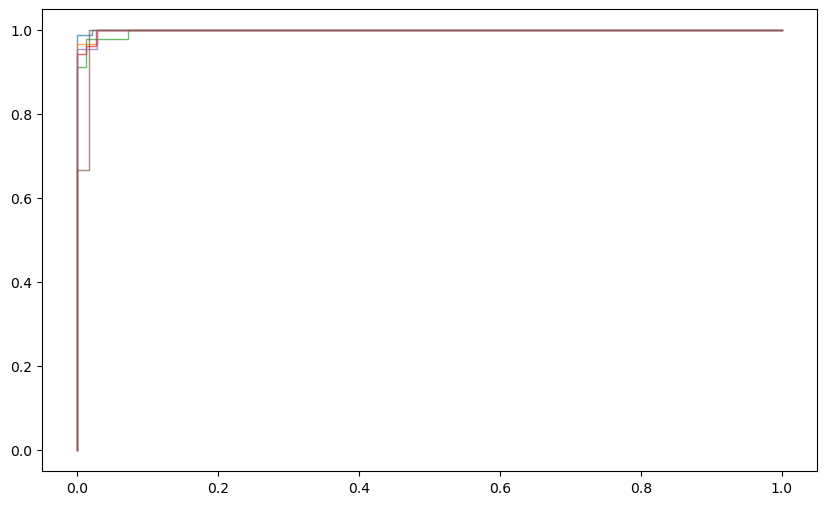

In [22]:
def linear_svm_classifier(X_train, y_train):
    svm_classifier = SVC(kernel='linear', probability=True)
    
    # Perform 6-fold cross-validation
    kf = KFold(n_splits=6)
    rocs = []
    aucs = []
    conf_matrices = []

    for train_index, test_index in kf.split(X_train):
        # Split the dataset
        X_train_splitted, X_test_splitted = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_splitted, y_test_splitted = y_train.iloc[train_index], y_train.iloc[test_index]

        # Train the model
        svm_classifier.fit(X_train_splitted, y_train_splitted)

        # Get the ROC curve
        y_probs = svm_classifier.predict_proba(X_test_splitted)[:, 1]
        fpr, tpr, threshold = roc_curve(y_test_splitted, y_probs)
        ROC = [{'fpr': f, 'tpr': t, 'threshold': th} for f, t, th in zip(fpr, tpr, threshold)]
        rocs.append(ROC)

        # Compute AUC
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        # Compute confusion matrix
        y_pred = svm_classifier.predict(X_test_splitted)
        conf_matrices.append(confusion_matrix_custom(y_test_splitted, y_pred))


    plt.figure(figsize=(10, 6))
    for i in range(len(rocs)):
        fpr_values = [entry['fpr'] for entry in rocs[i]]
        tpr_values = [entry['tpr'] for entry in rocs[i]]
        plt.plot(fpr_values, tpr_values, lw=1, alpha=0.7,
                 label='ROC fold %d (AUC = %0.2f)' % (i, aucs[i]))
    
    # Calculate mean confusion matrix
    mean_conf_matrix = np.mean(conf_matrices, axis=0)
    normalized_conf_matrix = mean_conf_matrix.astype('float') / mean_conf_matrix.sum(axis=1)[:, np.newaxis]

    print("Normalized Mean Confusion Matrix:")
    print(normalized_conf_matrix)

    # Find the best threshold 
    best_threshold = None
    max_diff = -1
    
    for roc_list in rocs:  
        for roc in roc_list:  
            fpr_value = roc['fpr']
            tpr_value = roc['tpr']
            threshold = roc['threshold']
            diff = tpr_value - fpr_value # Calculate the difference between tpr and fpr
            if diff > max_diff: # Maximize this difference
                max_diff = diff
                best_threshold = threshold


    print("Best threshold:", best_threshold)

start_time = time.time()
linear_svm_classifier(X_audit, y_audit)
end_time = time.time()
print("Runtime Performance:", end_time - start_time, "seconds")

Confusion matrix says:
True Negatives = 0.992,
False Negatives = 0.026,
True Positives = 0.974,
False Positives = 0.008

Accuracy : 0.98 , Precision : 0.99, Recall : 0.97

SVM performs better than KNN models since it also handles the false negatives very well. 

Runtime performance is also better than KNN's performance. 

For the ROC curve graph, it shows a good result for the model since the curve is very close the northwest point of the graph.

The best threshold is found by calculating the difference between tpr and fpr. The point that maximizes this difference gives the best threshold because this point is the most optimal point at northwest. According to this, the best threshold is 0.41.

# Part 4 : Linear SVM Regressor

In [23]:
def linear_svm_regressor(X_train, y_train):
    
    # Initialize Linear SVM Regressor
    svm_regressor = SVR(kernel='linear')
    
    # Perform 6-fold cross-validation
    kf = KFold(n_splits=6)
    mae_values = []
    for train_index, test_index in kf.split(X_train):
        # Split the dataset
        X_train_splitted, X_test_splitted = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_splitted, y_test_splitted = y_train.iloc[train_index], y_train.iloc[test_index]

        # Train the model
        svm_regressor.fit(X_train_splitted, y_train_splitted)

        # Predict on the test set
        y_pred = svm_regressor.predict(X_test_splitted)

        # Calculate mean absolute error
        mae = mean_absolute_error(y_test_splitted, y_pred)
        mae_values.append(mae)
        
    # Calculate mean MAE
    mean_mae = np.mean(mae_values)

    # Print mean MAE
    print("Mean Absolute Error:", mean_mae)
        

start_time = time.time()
linear_svm_regressor(X_day, y_day)
end_time = time.time()
print("Runtime Performance:", end_time - start_time, "seconds")

Mean Absolute Error: 768.4509629776582
Runtime Performance: 0.13226318359375 seconds


Mean absolute error is lower than the KNN regressor. This means that SVM regressor is better than KNN for this dataset. 

Runtime performance is also significantly better than KNN implementations. Therefore, SVM performs very well for this case.

# Part 5 : Radial Basis Function SVM Classifier

Normalized Mean Confusion Matrix:
[[0.98938429 0.01061571]
 [0.05245902 0.94754098]]
Best threshold: 0.10264766787637425
Runtime Performance: 0.11210322380065918 seconds


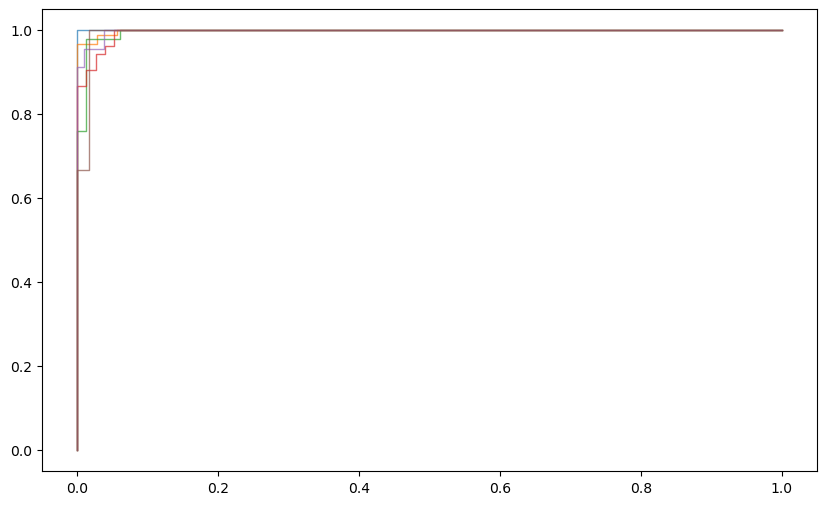

In [24]:
def rbf_svm_classifier(X_train, y_train):
    svm_classifier = SVC(kernel='rbf', probability=True)
    
    # Perform 6-fold cross-validation
    kf = KFold(n_splits=6)
    rocs = []
    aucs = []
    conf_matrices = []

    for train_index, test_index in kf.split(X_train):
        # Split the dataset
        X_train_splitted, X_test_splitted = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_splitted, y_test_splitted = y_train.iloc[train_index], y_train.iloc[test_index]

        # Train the model
        svm_classifier.fit(X_train_splitted, y_train_splitted)

        # Get the ROC curve
        y_probs = svm_classifier.predict_proba(X_test_splitted)[:, 1]
        fpr, tpr, threshold = roc_curve(y_test_splitted, y_probs)
        ROC = [{'fpr': f, 'tpr': t, 'threshold': th} for f, t, th in zip(fpr, tpr, threshold)]
        rocs.append(ROC)

        # Compute AUC
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        # Compute confusion matrix
        y_pred = svm_classifier.predict(X_test_splitted)
        conf_matrices.append(confusion_matrix_custom(y_test_splitted, y_pred))


    plt.figure(figsize=(10, 6))
    for i in range(len(rocs)):
        fpr_values = [entry['fpr'] for entry in rocs[i]]
        tpr_values = [entry['tpr'] for entry in rocs[i]]
        plt.plot(fpr_values, tpr_values, lw=1, alpha=0.7,
                 label='ROC fold %d (AUC = %0.2f)' % (i, aucs[i]))
    
    # Calculate mean confusion matrix
    mean_conf_matrix = np.mean(conf_matrices, axis=0)
    normalized_conf_matrix = mean_conf_matrix.astype('float') / mean_conf_matrix.sum(axis=1)[:, np.newaxis]

    print("Normalized Mean Confusion Matrix:")
    print(normalized_conf_matrix)

    # Find the best threshold 
    best_threshold = None
    max_diff = -1
    
    for roc_list in rocs:  
        for roc in roc_list:  
            fpr_value = roc['fpr']
            tpr_value = roc['tpr']
            threshold = roc['threshold']
            diff = tpr_value - fpr_value # Calculate the difference between tpr and fpr
            if diff > max_diff: # Maximize this difference
                max_diff = diff
                best_threshold = threshold


    print("Best threshold:", best_threshold)

start_time = time.time()
rbf_svm_classifier(X_audit, y_audit)
end_time = time.time()
print("Runtime Performance:", end_time - start_time, "seconds")

Confusion matrix says:
True Negatives = 0.989,
False Negatives = 0.052,
True Positives = 0.948,
False Positives = 0.011

Accuracy : 0.97 , Precision : 0.99, Recall : 0.95

SVM with radial basis function has considerably good performance. Its metric (accuracy and recall) values are slightly lower than linear SVM. However, it is still much better than KNN. 

Runtime performance is similar to linear SVM. Overall, it has a great performance. 

For the ROC curve graph, it shows a great result as linear SVM does.

Using the same technique, the best threshold for this model is 0.10.

# Part 6 : Decision Tree Classifier

In [25]:
def dt_classifier(X_train, y_train):
    
    # Build the decision trees with two pruning options
    dt_classifier_pre_pruned = DecisionTreeClassifier(criterion='entropy', max_depth=2)
    dt_classifier_post_pruned = DecisionTreeClassifier(criterion='entropy', ccp_alpha=0.01)
    
    # Perform 6-fold cross-validation
    kf = KFold(n_splits=6)
    for train_index, test_index in kf.split(X_train):
        # Split the dataset
        X_train_splitted, X_test_splitted = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_splitted, y_test_splitted = y_train.iloc[train_index], y_train.iloc[test_index]

        # Train pre-pruned tree
        dt_classifier_pre_pruned.fit(X_train_splitted, y_train_splitted)

        # Train post-pruned tree
        dt_classifier_post_pruned.fit(X_train_splitted, y_train_splitted)

        # Evaluate the tree
        pre_pruning_test_score = dt_classifier_pre_pruned.score(X_test_splitted, y_test_splitted)
        post_pruning_test_score = dt_classifier_post_pruned.score(X_test_splitted, y_test_splitted)

        print("Pre-Pruning Tree Accuracy:", pre_pruning_test_score)
        print("Post-Pruning Tree Accuracy:", post_pruning_test_score)
        
    return dt_classifier_pre_pruned, dt_classifier_post_pruned 

dt_classifier_pre_pruned, dt_classifier_post_pruned = dt_classifier(X_audit, y_audit)
    

Pre-Pruning Tree Accuracy: 1.0
Post-Pruning Tree Accuracy: 1.0
Pre-Pruning Tree Accuracy: 0.9923076923076923
Post-Pruning Tree Accuracy: 1.0
Pre-Pruning Tree Accuracy: 0.9844961240310077
Post-Pruning Tree Accuracy: 0.9922480620155039
Pre-Pruning Tree Accuracy: 0.9844961240310077
Post-Pruning Tree Accuracy: 1.0
Pre-Pruning Tree Accuracy: 0.9922480620155039
Post-Pruning Tree Accuracy: 1.0
Pre-Pruning Tree Accuracy: 1.0
Post-Pruning Tree Accuracy: 1.0


Pre-pruning is set to the depth 2. Post-pruning is set to the ccp_alpha 0.01 (Minimal cost-complexity pruning is an algorithm used to prune a tree to avoid over-fitting). 

Pre-pruning results depend on the chosen depth. For this choice, it is not as accurate as post-pruning tree. However, the results from the both trees are almost 1 so this says there might be overfitting.

When we look at the extracted rules below, we can see that post-pruning tree has more branches and pre-pruning tree is limited to the depth 2.

In [26]:
def extract_rules(tree, feature_names, node, is_classification, indent=""):
    if tree.feature[node] != -2:
        feature = feature_names[tree.feature[node]]
        threshold = tree.threshold[node]
        print(f"{indent}|--- {feature} <= {threshold:.2f}")
        extract_rules(tree, feature_names, tree.children_left[node], is_classification, indent + "|   ")
        print(f"{indent}|--- {feature} > {threshold:.2f}")
        extract_rules(tree, feature_names, tree.children_right[node], is_classification, indent + "|   ")
    else:
        if is_classification:
            value = int(tree.value[node].argmax())  # Get the class with the highest count
            print(f"{indent}|--- class: {value}")
        else:
            value = tree.value[node][0][0]  # Predicted value for regression
            print(f"{indent}|--- value: {value:.2f}")

In [27]:
print("Pre-pruning Tree Rules:")
extract_rules(dt_classifier_pre_pruned.tree_, columns_to_normalize_audit, 0, True)

Pre-pruning Tree Rules:
|--- Inherent_Risk <= -0.23
|   |--- CONTROL_RISK <= 0.96
|   |   |--- class: 0
|   |--- CONTROL_RISK > 0.96
|   |   |--- class: 1
|--- Inherent_Risk > -0.23
|   |--- class: 1


In [28]:
print("Post-pruning Tree Rules:")
extract_rules(dt_classifier_post_pruned.tree_, columns_to_normalize_audit, 0, True)

Post-pruning Tree Rules:
|--- Inherent_Risk <= -0.23
|   |--- RiSk_E <= 1.66
|   |   |--- District_Loss <= 0.40
|   |   |   |--- class: 0
|   |   |--- District_Loss > 0.40
|   |   |   |--- TOTAL <= -0.22
|   |   |   |   |--- class: 0
|   |   |   |--- TOTAL > -0.22
|   |   |   |   |--- class: 1
|   |--- RiSk_E > 1.66
|   |   |--- class: 1
|--- Inherent_Risk > -0.23
|   |--- class: 1


# Part 7 : Decision Tree Regressor

In [29]:
def dt_regressor(X_train, y_train):
    
    # Build the decision trees with two pruning options
    dt_regressor_pre_pruned = DecisionTreeRegressor(max_depth=2)
    dt_regressor_post_pruned = DecisionTreeRegressor(ccp_alpha=0.01)
    
    # Perform 6-fold cross-validation
    kf = KFold(n_splits=6)
    for train_index, test_index in kf.split(X_train):
        # Split the dataset
        X_train_splitted, X_test_splitted = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_splitted, y_test_splitted = y_train.iloc[train_index], y_train.iloc[test_index]

        # Train pre-pruned tree
        dt_regressor_pre_pruned.fit(X_train_splitted, y_train_splitted)

        # Train post-pruned tree
        dt_regressor_post_pruned.fit(X_train_splitted, y_train_splitted)

        # Evaluate the tree
        pre_pruning_test_score = dt_regressor_pre_pruned.score(X_test_splitted, y_test_splitted)
        post_pruning_test_score = dt_regressor_post_pruned.score(X_test_splitted, y_test_splitted)

        print("Pre-Pruning Tree Accuracy:", pre_pruning_test_score)
        print("Post-Pruning Tree Accuracy:", post_pruning_test_score)
        
    return dt_regressor_pre_pruned, dt_regressor_post_pruned

dt_regressor_pre_pruned, dt_regressor_post_pruned = dt_regressor(X_day, y_day)

Pre-Pruning Tree Accuracy: 0.49714385943456774
Post-Pruning Tree Accuracy: 0.9328960424997911
Pre-Pruning Tree Accuracy: -1.083655952604818
Post-Pruning Tree Accuracy: 0.7623804402548249
Pre-Pruning Tree Accuracy: 0.5643271599067563
Post-Pruning Tree Accuracy: 0.9753097555904336
Pre-Pruning Tree Accuracy: 0.6245547167521159
Post-Pruning Tree Accuracy: 0.9731921597117443
Pre-Pruning Tree Accuracy: -0.2717478889370015
Post-Pruning Tree Accuracy: 0.8638210190396074
Pre-Pruning Tree Accuracy: 0.6327545040190842
Post-Pruning Tree Accuracy: 0.973264114906303


Pre-pruning is set the depth 2. Post-pruning is set to the ccp_alpha 0.01 (Minimal cost-complexity pruning is an algorithm used to prune a tree to avoid over-fitting). 

Pre-pruning tree works poorly since we can see that the accuracy is too low and even negative for some cases. (The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse)) Post-pruning works better. For some cases it is as low as 0.76 but it can be as high as 0.97.

However, when we look at the extracted rules of the post-pruning tree below, we can see that the tree is too complex. Having a complex tree is not something we want.

In [30]:
print("Pre-pruning Tree Rules:")
extract_rules(dt_regressor_pre_pruned.tree_, columns_to_normalize_day, 0, False)

Pre-pruning Tree Rules:
|--- registered <= -0.48
|   |--- registered <= -0.99
|   |   |--- value: 1695.79
|   |--- registered > -0.99
|   |   |--- value: 3279.07
|--- registered > -0.48
|   |--- instant <= 0.34
|   |   |--- value: 4415.41
|   |--- instant > 0.34
|   |   |--- value: 6486.15


In [31]:
print("Post-pruning Tree Rules:")
extract_rules(dt_regressor_post_pruned.tree_, columns_to_normalize_day, 0, False)

Post-pruning Tree Rules:
|--- registered <= -0.48
|   |--- registered <= -0.99
|   |   |--- registered <= -1.45
|   |   |   |--- registered <= -1.75
|   |   |   |   |--- registered <= -1.83
|   |   |   |   |   |--- registered <= -1.95
|   |   |   |   |   |   |--- mnth <= -1.31
|   |   |   |   |   |   |   |--- instant <= -1.61
|   |   |   |   |   |   |   |   |--- value: 506.00
|   |   |   |   |   |   |   |--- instant > -1.61
|   |   |   |   |   |   |   |   |--- value: 431.00
|   |   |   |   |   |   |--- mnth > -1.31
|   |   |   |   |   |   |   |--- weathersit <= 0.19
|   |   |   |   |   |   |   |   |--- value: 754.00
|   |   |   |   |   |   |   |--- weathersit > 0.19
|   |   |   |   |   |   |   |   |--- hum <= 2.02
|   |   |   |   |   |   |   |   |   |--- temp <= -0.95
|   |   |   |   |   |   |   |   |   |   |--- value: 627.00
|   |   |   |   |   |   |   |   |   |--- temp > -0.95
|   |   |   |   |   |   |   |   |   |   |--- value: 623.00
|   |   |   |   |   |   |   |   |--- hum > 2.02
|